In [132]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd
from PIL import Image
import torch.optim as optim
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

In [133]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    # 'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    # 'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    # 'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    # 'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

In [134]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [135]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # 1×1×64
        self.max_pool = nn.AdaptiveMaxPool2d(1) # 1×1×64

        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False), # 1×1×4
                               nn.ReLU(), # 1×1×4
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)) # 1×1×64
        self.sigmoid = nn.Sigmoid() # 1×1×64

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x)) # 1×1×64
        max_out = self.fc(self.max_pool(x)) # 1×1×64
        out = avg_out + max_out # 1×1×64
        return self.sigmoid(out) # 1×1×64

In [136]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True) # 56×56×1
        max_out, _ = torch.max(x, dim=1, keepdim=True) # 56×56×1
        x = torch.cat([avg_out, max_out], dim=1) # 56×56×2
        x = self.conv1(x) # 56×56×1
        return self.sigmoid(x) # 56×56×1

In [137]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride) # 56*56*64 
        self.bn1 = nn.BatchNorm2d(planes) # 56*56*64 
        self.relu = nn.ReLU(inplace=True) # 56*56*64 
        self.conv2 = conv3x3(planes, planes) # 56*56*64 
        self.bn2 = nn.BatchNorm2d(planes)

        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x # (56×56×64, 56×56×64), (56×56×64, 28x28x128), (28x28x128, 14x14x256)

        out = self.conv1(x) # (56*56*64, 56×56×64), (28*28*128, 28*28*128), (14x14x256, 14x14x256)
        out = self.bn1(out) # (56*56*64, 56×56×64), (28*28*128, 28*28*128), (14x14x256, 14x14x256)
        out = self.relu(out) # (56*56*64, 56×56×64), (28*28*128, 28*28*128), (14x14x256, 14x14x256)

        out = self.conv2(out) # (56*56*64, 56×56×64), (28*28*128, 28*28*128), (14x14x256, 14x14x256)
        out = self.bn2(out) # (56*56*64, 56×56×64), (28*28*128, 28*28*128), (14x14x256, 14x14x256)

        out = self.ca(out) * out # (1*1*64) * (56*56*64) = (56*56*64; 56×56×64); (28*28*128; 28*28*128); (14x14x256, 14x14x256);
        out = self.sa(out) * out # (56×56×1) * (56×56×64) = (56×56×64; 56×56×64); (28x28x128; 28*28*128); (14x14x256, 14x14x256);

        if self.downsample is not None:
            residual = self.downsample(x) # 28*28*128, 14x14x256 

        out += residual # (56×56×64, 56×56×64), (28*28*128, 28*28*128), (14x14x256, 14x14x256)
        out = self.relu(out) # (56×56×64, 56×56×64), (28*28*128, 28*28*128), (14x14x256, 14x14x256)

        return out

In [138]:
class PatchExtraction(nn.Module):
    def __init__(self):
        super(PatchExtraction, self).__init__()

        self.depthwise_conv1 = nn.Conv2d(256, 256, kernel_size=4, stride=4, padding=1, groups=256)  # Input: 14x14x256, Output: 4×4×256     
        self.pointwise_conv1 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)  # Output: 4×4×256
        
        self.depthwise_conv2 = nn.Conv2d(256, 256, kernel_size=2, stride=2, padding=0, groups=256)  # Output: 2×2×256
        self.pointwise_conv2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)  # Output: 2×2×256

        self.conv3 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)  # Output: 2×2×256

    def forward(self, x):
        x = F.relu(self.depthwise_conv1(x))
        x = F.relu(self.pointwise_conv1(x))

        x = F.relu(self.depthwise_conv2(x))
        x = F.relu(self.pointwise_conv2(x))

        x = F.relu(self.conv3(x))
        
        return x

In [139]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_heads, num_classes=7):
        self.inplanes = 64
        self.num_heads = num_heads
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False) # 112*112*64
        self.bn1 = nn.BatchNorm2d(64) # 112*112*64
        self.relu = nn.ReLU(inplace=True) # 112*112*64
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 56*56*64
        self.layer1 = self._make_layer(block, 64, layers[0]) # 56×56×64
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2) # 28*28*128
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2) # 14*14*256 
        self.patch_extraction = PatchExtraction() #  2×2×256

        self.attention = nn.MultiheadAttention(256, num_heads)
        # Input will be changed to the size 4x32x256 (see below forward code) which will be used as query key value 
        # weight matrix will have the size 256*(256) as default value (256) is default value we can change this by using vdim and kdim attributes of the class
        # else weight matrix will have embed_dim * kdim for key matrix , after multiplying 4x32x256 will be the ouptut like this we will be having key query 
        # value matrix (Q)x(K.T)  query and key transpose multiplication will produce of size 4x32x4 and dividing it with sqrt(256) , this dividing saves the 
        # variance and makes it around 1 and also it gets trained without gradient saturation and finally it applies soft max on to this making each row value
        #sum up to 1 of 4x4 matrix this for 32 batch size and multiplying it with 4x32x256 i.e 4x32x4 with 4x32x256 value matrix outputs the matrix 4x32x256
        self.layer_norm = nn.LayerNorm(256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1) 

        self.classifier = nn.Linear(256, num_classes)

        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                fan_out = m.weight.size(0)  
                fan_in = m.weight.size(1) if m.weight.dim() > 1 else 0  
                init_range = 1.0 / math.sqrt(fan_in + fan_out)
                m.weight.data.uniform_(-init_range, init_range)
                if m.bias is not None:
                    m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False), # 28*28*128, 14×14×256, 
                nn.BatchNorm2d(planes * block.expansion), # 28*28*128, 14×14×256
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.patch_extraction(x) 

        batch_size, channels, height, width = x.shape
        x = x.view(batch_size, channels, height*width).permute(2,0,1)

        query = x
        key = x
        value = x

        attn_output, _ = self.attention(query, key, value)
        x = self.layer_norm(attn_output + x)
        x = x.permute(1,2,0).view(batch_size, channels, height, width) # 32*256*2*2
        x = self.global_avg_pool(x).view(batch_size, -1) # 32*256

        logits = self.classifier(x)

        return logits

In [288]:
def resnet18_cbam(pretrained=True, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    num_heads = 1
    model = ResNet(BasicBlock, [2, 2, 2, 2], num_heads)
#     if pretrained:
#         pretrained_state_dict = model_zoo.load_url(model_urls['resnet18'])
#         now_state_dict        = model.state_dict()
#         now_state_dict.update(pretrained_state_dict)
#         model.load_state_dict(now_state_dict, strict=False)
    
    if pretrained:
        checkpoint = torch.load(r"/kaggle/input/qdawsfegdrhfjghk/aug_epoch_12_acc_82.20_newmodel.pth")
        model.load_state_dict(checkpoint['model_state_dict'],strict=False)

    
    return model

In [289]:
model = resnet18_cbam()

/tmp/ipykernel_30/3634161233.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"/kaggle/input/qdawsfegdrhfjghk/aug_epoch_12_acc_82.20_newmodel.pt

In [292]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [293]:
model = model.to(device)

In [294]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [295]:
aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by up to 5 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Slightly change brightness and contrast
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

# Class Labels are 0-Indexed CAREFULL

In [150]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        self.data_frame = pd.read_csv(csv_file)

        assert 'image' in self.data_frame.columns
        assert 'label' in self.data_frame.columns

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx, 0]  
        class_label = self.data_frame.iloc[idx, 1] - 1  

        class_folder = os.path.join(self.image_dir, str(class_label+1))  
        img_path = os.path.join(class_folder, img_name)

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, class_label

In [151]:
image_directory = r"/kaggle/input/raf-db-dataset/DATASET/train"  
csv_file_path = r"/kaggle/input/raf-db-dataset/train_labels.csv"

In [152]:
train_dataset = CustomImageDataset(image_dir=image_directory, csv_file=csv_file_path, transform=transform)

In [153]:
aug_train_dataset = CustomImageDataset(image_directory, csv_file_path, aug_transform)

In [154]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, pin_memory=True, shuffle=True)

In [155]:
aug_train_loader = DataLoader(aug_train_dataset, batch_size=32, num_workers=4, pin_memory=True, shuffle=True)

In [156]:
torch.cuda.empty_cache()

In [158]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [159]:
os.makedirs('models', exist_ok=True)

In [160]:
os.getcwd()

'/kaggle/working'

In [161]:
test_image_directory = r"/kaggle/input/raf-db-dataset/DATASET/test"
test_csv_file_path = r"/kaggle/input/raf-db-dataset/test_labels.csv"

In [162]:
test_dataset = CustomImageDataset(test_image_directory, test_csv_file_path, transform)

In [163]:
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4, pin_memory=True, shuffle=True)

In [164]:
def train(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=20):
    best_accuracy = 75
    model.train()
    for epoch in range(1, num_epochs+1):
        running_loss = 0.0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs=model(images)
            loss = criterion(outputs,labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}')
        if epoch > 1 :
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in tqdm(test_loader):
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    logits = model(images)
                    
                    _, predicted = torch.max(logits, 1)
                    total += labels.size(0)  
                    correct += (predicted == labels).sum().item()
            accuracy = 100*(correct/total)
            print(f"test_Acc : {accuracy}")
                
            if accuracy > best_accuracy or epoch%20==0:
                best_accuracy = accuracy
                torch.save({'iter': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),},
                        os.path.join('models', f"aug_epoch_{epoch}_acc_{accuracy:.2f}_newmodel.pth"))
                print('Model saved.')
            model.train()

In [95]:
train(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=20)

100%|██████████| 384/384 [00:37<00:00, 10.14it/s]


Epoch [1/20], Loss: 1.3731


100%|██████████| 384/384 [00:37<00:00, 10.31it/s]


Epoch [2/20], Loss: 0.9905


100%|██████████| 96/96 [00:05<00:00, 18.99it/s]


test_Acc : 68.48109517601043


100%|██████████| 384/384 [00:37<00:00, 10.29it/s]


Epoch [3/20], Loss: 0.7745


100%|██████████| 96/96 [00:04<00:00, 23.95it/s]


test_Acc : 70.73011734028684
Model saved.


100%|██████████| 384/384 [00:37<00:00, 10.28it/s]


Epoch [4/20], Loss: 0.6318


100%|██████████| 96/96 [00:03<00:00, 24.03it/s]


test_Acc : 73.82659713168188
Model saved.


100%|██████████| 384/384 [00:37<00:00, 10.29it/s]


Epoch [5/20], Loss: 0.5022


100%|██████████| 96/96 [00:03<00:00, 24.45it/s]


test_Acc : 75.91264667535854
Model saved.


100%|██████████| 384/384 [00:37<00:00, 10.29it/s]


Epoch [6/20], Loss: 0.3788


100%|██████████| 96/96 [00:03<00:00, 24.32it/s]


test_Acc : 76.17340286831812
Model saved.


100%|██████████| 384/384 [00:37<00:00, 10.29it/s]


Epoch [7/20], Loss: 0.2866


100%|██████████| 96/96 [00:04<00:00, 23.42it/s]


test_Acc : 76.49934810951761
Model saved.


100%|██████████| 384/384 [00:37<00:00, 10.28it/s]


Epoch [8/20], Loss: 0.2066


100%|██████████| 96/96 [00:03<00:00, 24.18it/s]


test_Acc : 76.76010430247719
Model saved.


100%|██████████| 384/384 [00:37<00:00, 10.29it/s]


Epoch [9/20], Loss: 0.1458


100%|██████████| 96/96 [00:04<00:00, 23.49it/s]


test_Acc : 75.19556714471969


100%|██████████| 384/384 [00:37<00:00, 10.27it/s]


Epoch [10/20], Loss: 0.1244


100%|██████████| 96/96 [00:04<00:00, 23.39it/s]


test_Acc : 75.13037809647979


100%|██████████| 384/384 [00:37<00:00, 10.27it/s]


Epoch [11/20], Loss: 0.0999


100%|██████████| 96/96 [00:03<00:00, 24.35it/s]


test_Acc : 76.53194263363756


100%|██████████| 384/384 [00:37<00:00, 10.29it/s]


Epoch [12/20], Loss: 0.0575


100%|██████████| 96/96 [00:04<00:00, 22.59it/s]


test_Acc : 76.36897001303781


100%|██████████| 384/384 [00:37<00:00, 10.28it/s]


Epoch [13/20], Loss: 0.0656


100%|██████████| 96/96 [00:03<00:00, 24.31it/s]


test_Acc : 77.15123859191657
Model saved.


100%|██████████| 384/384 [00:37<00:00, 10.29it/s]


Epoch [14/20], Loss: 0.0921


100%|██████████| 96/96 [00:03<00:00, 24.05it/s]


test_Acc : 77.73794002607562
Model saved.


100%|██████████| 384/384 [00:37<00:00, 10.27it/s]


Epoch [15/20], Loss: 0.0495


100%|██████████| 96/96 [00:03<00:00, 24.33it/s]


test_Acc : 78.16166883963494
Model saved.


100%|██████████| 384/384 [00:37<00:00, 10.29it/s]


Epoch [16/20], Loss: 0.0695


100%|██████████| 96/96 [00:04<00:00, 23.93it/s]


test_Acc : 75.65189048239895


100%|██████████| 384/384 [00:37<00:00, 10.30it/s]


Epoch [17/20], Loss: 0.0451


100%|██████████| 96/96 [00:04<00:00, 23.85it/s]


test_Acc : 77.11864406779661


100%|██████████| 384/384 [00:37<00:00, 10.30it/s]


Epoch [18/20], Loss: 0.0422


100%|██████████| 96/96 [00:04<00:00, 23.79it/s]


test_Acc : 75.78226857887876


100%|██████████| 384/384 [00:37<00:00, 10.29it/s]


Epoch [19/20], Loss: 0.0545


100%|██████████| 96/96 [00:04<00:00, 22.00it/s]


test_Acc : 76.95567144719688


100%|██████████| 384/384 [00:37<00:00, 10.30it/s]


Epoch [20/20], Loss: 0.0529


100%|██████████| 96/96 [00:04<00:00, 23.82it/s]

test_Acc : 77.54237288135593
Model saved.


In [165]:
train(model, aug_train_loader, test_loader, criterion, optimizer, device, num_epochs=40)

100%|██████████| 384/384 [00:47<00:00,  8.11it/s]


Epoch [1/40], Loss: 0.6193


100%|██████████| 384/384 [00:45<00:00,  8.42it/s]


Epoch [2/40], Loss: 0.5053


100%|██████████| 96/96 [00:04<00:00, 19.97it/s]


test_Acc : 79.5632333767927
Model saved.


100%|██████████| 384/384 [00:45<00:00,  8.44it/s]


Epoch [3/40], Loss: 0.4596


100%|██████████| 96/96 [00:04<00:00, 22.85it/s]


test_Acc : 80.24771838331161
Model saved.


100%|██████████| 384/384 [00:45<00:00,  8.45it/s]


Epoch [4/40], Loss: 0.4096


100%|██████████| 96/96 [00:03<00:00, 24.39it/s]


test_Acc : 79.85658409387223


100%|██████████| 384/384 [00:45<00:00,  8.46it/s]


Epoch [5/40], Loss: 0.3955


100%|██████████| 96/96 [00:04<00:00, 22.03it/s]


test_Acc : 79.40026075619296


100%|██████████| 384/384 [00:45<00:00,  8.44it/s]


Epoch [6/40], Loss: 0.3616


100%|██████████| 96/96 [00:03<00:00, 24.13it/s]


test_Acc : 78.0638852672751


100%|██████████| 384/384 [00:45<00:00,  8.36it/s]


Epoch [7/40], Loss: 0.3418


100%|██████████| 96/96 [00:04<00:00, 23.87it/s]


test_Acc : 79.23728813559322


100%|██████████| 384/384 [00:45<00:00,  8.45it/s]


Epoch [8/40], Loss: 0.3234


100%|██████████| 96/96 [00:03<00:00, 24.29it/s]


test_Acc : 79.13950456323337


100%|██████████| 384/384 [00:46<00:00,  8.34it/s]


Epoch [9/40], Loss: 0.2921


100%|██████████| 96/96 [00:03<00:00, 24.45it/s]


test_Acc : 80.50847457627118
Model saved.


100%|██████████| 384/384 [00:45<00:00,  8.46it/s]


Epoch [10/40], Loss: 0.2692


100%|██████████| 96/96 [00:03<00:00, 24.08it/s]


test_Acc : 79.79139504563233


100%|██████████| 384/384 [00:46<00:00,  8.32it/s]


Epoch [11/40], Loss: 0.2696


100%|██████████| 96/96 [00:03<00:00, 24.29it/s]


test_Acc : 79.82398956975229


100%|██████████| 384/384 [00:45<00:00,  8.45it/s]


Epoch [12/40], Loss: 0.2412


100%|██████████| 96/96 [00:04<00:00, 23.98it/s]


test_Acc : 82.20338983050848
Model saved.


100%|██████████| 384/384 [00:45<00:00,  8.37it/s]


Epoch [13/40], Loss: 0.2327


100%|██████████| 96/96 [00:03<00:00, 24.04it/s]


test_Acc : 79.4328552803129


100%|██████████| 384/384 [00:45<00:00,  8.47it/s]


Epoch [14/40], Loss: 0.2184


100%|██████████| 96/96 [00:04<00:00, 23.98it/s]


test_Acc : 81.16036505867015


100%|██████████| 384/384 [00:46<00:00,  8.31it/s]


Epoch [15/40], Loss: 0.2104


100%|██████████| 96/96 [00:03<00:00, 24.28it/s]


test_Acc : 81.25814863103


100%|██████████| 384/384 [00:45<00:00,  8.46it/s]


Epoch [16/40], Loss: 0.1949


100%|██████████| 96/96 [00:04<00:00, 21.90it/s]


test_Acc : 81.87744458930901


100%|██████████| 384/384 [00:45<00:00,  8.47it/s]


Epoch [17/40], Loss: 0.1816


100%|██████████| 96/96 [00:04<00:00, 23.77it/s]


test_Acc : 79.33507170795306


100%|██████████| 384/384 [00:45<00:00,  8.39it/s]


Epoch [18/40], Loss: 0.1769


100%|██████████| 96/96 [00:04<00:00, 23.87it/s]


test_Acc : 81.87744458930901


100%|██████████| 384/384 [00:45<00:00,  8.46it/s]


Epoch [19/40], Loss: 0.1810


100%|██████████| 96/96 [00:04<00:00, 23.91it/s]


test_Acc : 81.25814863103


100%|██████████| 384/384 [00:46<00:00,  8.35it/s]


Epoch [20/40], Loss: 0.1646


100%|██████████| 96/96 [00:03<00:00, 24.19it/s]


test_Acc : 79.82398956975229
Model saved.


100%|██████████| 384/384 [00:45<00:00,  8.41it/s]


Epoch [21/40], Loss: 0.1539


100%|██████████| 96/96 [00:03<00:00, 24.33it/s]


test_Acc : 80.14993481095176
Model saved.


100%|██████████| 384/384 [00:46<00:00,  8.34it/s]


Epoch [22/40], Loss: 0.1509


100%|██████████| 96/96 [00:04<00:00, 24.00it/s]


test_Acc : 80.80182529335072
Model saved.


100%|██████████| 384/384 [00:45<00:00,  8.46it/s]


Epoch [23/40], Loss: 0.1530


100%|██████████| 96/96 [00:03<00:00, 24.04it/s]


test_Acc : 79.46544980443285


100%|██████████| 384/384 [00:45<00:00,  8.36it/s]


Epoch [24/40], Loss: 0.1493


100%|██████████| 96/96 [00:04<00:00, 23.75it/s]


test_Acc : 78.78096479791395


100%|██████████| 384/384 [00:45<00:00,  8.52it/s]


Epoch [25/40], Loss: 0.1278


100%|██████████| 96/96 [00:03<00:00, 24.21it/s]


test_Acc : 80.01955671447197


100%|██████████| 384/384 [00:45<00:00,  8.42it/s]


Epoch [26/40], Loss: 0.1265


100%|██████████| 96/96 [00:03<00:00, 24.42it/s]


test_Acc : 80.76923076923077


100%|██████████| 384/384 [00:45<00:00,  8.50it/s]


Epoch [27/40], Loss: 0.1238


100%|██████████| 96/96 [00:03<00:00, 24.14it/s]


test_Acc : 80.34550195567145


100%|██████████| 384/384 [00:45<00:00,  8.42it/s]


Epoch [28/40], Loss: 0.1267


100%|██████████| 96/96 [00:04<00:00, 23.86it/s]


test_Acc : 81.51890482398957
Model saved.


100%|██████████| 384/384 [00:45<00:00,  8.49it/s]


Epoch [29/40], Loss: 0.1182


100%|██████████| 96/96 [00:04<00:00, 22.45it/s]


test_Acc : 80.14993481095176


100%|██████████| 384/384 [00:45<00:00,  8.50it/s]


Epoch [30/40], Loss: 0.1071


100%|██████████| 96/96 [00:03<00:00, 24.39it/s]


test_Acc : 80.80182529335072


100%|██████████| 384/384 [00:45<00:00,  8.48it/s]


Epoch [31/40], Loss: 0.1120


100%|██████████| 96/96 [00:04<00:00, 23.31it/s]


test_Acc : 81.97522816166884
Model saved.


100%|██████████| 384/384 [00:45<00:00,  8.46it/s]


Epoch [32/40], Loss: 0.1087


100%|██████████| 96/96 [00:03<00:00, 24.49it/s]


test_Acc : 81.58409387222947


100%|██████████| 384/384 [00:45<00:00,  8.38it/s]


Epoch [33/40], Loss: 0.1094


100%|██████████| 96/96 [00:03<00:00, 24.53it/s]


test_Acc : 81.77966101694916


100%|██████████| 384/384 [00:45<00:00,  8.49it/s]


Epoch [34/40], Loss: 0.1145


100%|██████████| 96/96 [00:03<00:00, 24.37it/s]


test_Acc : 81.58409387222947


100%|██████████| 384/384 [00:46<00:00,  8.32it/s]


Epoch [35/40], Loss: 0.1000


100%|██████████| 96/96 [00:04<00:00, 23.71it/s]


test_Acc : 82.13820078226858
Model saved.


100%|██████████| 384/384 [00:45<00:00,  8.44it/s]


Epoch [36/40], Loss: 0.0966


100%|██████████| 96/96 [00:04<00:00, 23.62it/s]


test_Acc : 80.47588005215124


100%|██████████| 384/384 [00:45<00:00,  8.40it/s]


Epoch [37/40], Loss: 0.0955


100%|██████████| 96/96 [00:03<00:00, 24.42it/s]


test_Acc : 80.60625814863103


100%|██████████| 384/384 [00:45<00:00,  8.48it/s]


Epoch [38/40], Loss: 0.1049


100%|██████████| 96/96 [00:03<00:00, 24.27it/s]


test_Acc : 79.49804432855281


100%|██████████| 384/384 [00:45<00:00,  8.41it/s]


Epoch [39/40], Loss: 0.0929


100%|██████████| 96/96 [00:03<00:00, 24.33it/s]


test_Acc : 81.45371577574967


100%|██████████| 384/384 [00:45<00:00,  8.46it/s]


Epoch [40/40], Loss: 0.0984


100%|██████████| 96/96 [00:04<00:00, 23.74it/s]


test_Acc : 79.79139504563233
Model saved.


In [296]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        
        _, predicted = torch.max(logits, 1)
        total += labels.size(0) 
        correct += (predicted == labels).sum().item()
accuracy = 100*(correct/total)




accuracy


100%|██████████| 96/96 [00:05<00:00, 17.50it/s]


82.20338983050848

In [298]:
all_preds=[]
all_labels=[]
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs,1)
#         predicted+=1
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

100%|██████████| 96/96 [00:04<00:00, 22.38it/s]


In [299]:
accuracy = accuracy_score(all_labels, all_preds)
accuracy

0.8220338983050848

In [300]:
cm = confusion_matrix(all_labels, all_preds)
cm

array([[ 258,    8,    4,   12,   14,    5,   28],
       [  13,   39,    2,    3,   10,    3,    4],
       [   1,    2,   76,   12,   24,   12,   33],
       [   8,    0,   14, 1093,   15,    3,   52],
       [   2,    2,   18,   22,  364,    3,   67],
       [   5,   10,   13,   14,   10,  102,    8],
       [  10,    1,   18,   29,   30,    2,  590]])

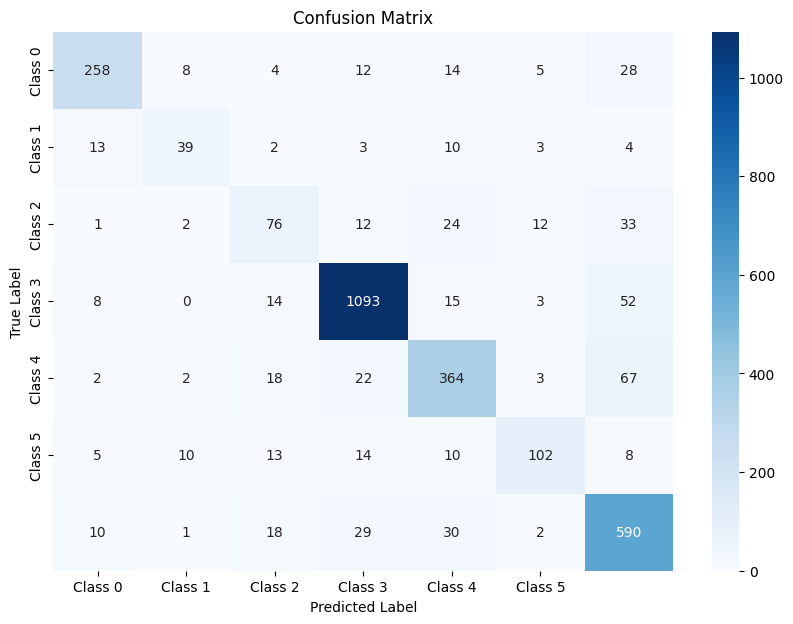

In [301]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(6)], yticklabels=[f'Class {i}' for i in range(6)])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()